## Kernel SVM
The classical Support Vector Machine (SVM) is a powerful linear classifier that provides a robust definition of a classifying hyperplane with the maximum margin hyperplane. However, in many real-world datasets, the classes are not linearly separable. This limits the applicability of the standard (linear) SVM.

The typical machine learning way to apply linear models to nonlinear data is to define a feature transformation that makes the nonlinear data appear linear in the transformed feature space. Often, the transformed feature space is higher dimensional than the original feature space. We have seen this for example in regression: applying polynomial basis functions creates a design matrix that is higher dimensional than the data matrix. Applying the linear regression on the design matrix solves the nonlinear regression problem in the original feature space. 


For example, {numref}`non_linear_transformation_fig` illustrates how non-linearly separable classes can be transformed into a space where the classes are linearly separable.

```{figure} /images/classification/degree2_monomials.png
---
height: 320px
name: non_linear_transformation_fig
align: left
---
Non-linear transformation $\phi: \mathbb{R}^2 \rightarrow \mathbb{R}^3 $ mapping feature vectors $ {\bf x}\in\mathbb{R}^2$ to transformed feature vectors $ {\bf z}\in\mathbb{R}^3$ with the transformation $ {\bf z} = \phi({\bf x}) = ( x_1^2 , \sqrt{2} x_1 x_2 , x_2^2 ) $.  (borrowed from {cite}`scholkopfmax2013max`).
```

The challenge of this approach is the high dimensionality that is often required to make classes linearly separable in the transformed feature space. The SVM dual objective enables here the application of the so-called kernel trick, that allows even for the efficient computation of infinite dimensional feature transformations. 

### Kernel trick

The kernel trick is applicable when an objective can be formulated such that the only occurrences of data points are in inner products between data points $\vvec{x}_i^\top\vvec{x}_j$. The kernel trick is to replace the inner products with a kernel function $k(\vvec{x}_i,\vvec{x}_j)$. The kernel function represents an implicit computation of the inner product in a transformed feature space, that does not require the compuattion of the feature transformation itself: $k(\vvec{x}_i,\vvec{x}_j)=\phi(\vvec{x}_i)^\top\phi(\vvec{x}_j)$. The kernel function has an interpretation as a similarity measure between two vectors. Choosing a kernel is hence equivalent to choosing what kind of similarity measure is considered suitable for the classification task. Hnece, although we are dealing with very high-dimensional feature transformations that are not easy to understand, the inner product defined by the kernel has an interpretation as a similarity measure that still allows for understanding what the model is doing.
```{prf:definition} Kernel
A **kernel function** $k:\mathbb{R}^d\times\mathbb{R}^d\rightarrow \mathbb{R}$ maps two $d$-dimensional vectors to a nonnegative value that has an interpretation as an inner product similarity measure in a transformed feature space. That is, a feature transformation $\phi:\mathbb{R}^d\rightarrow \mathbb{R}^p$ exists such that
$$k(\vvec{x}_i,\vvec{x}_j) = \phi(\vvec{x}_i)^\top\phi(\vvec{x}_j).$$
Given a set of vectors $\vvec{x}_i$ for $1\leq i\leq n$, then we define the **kernel matrix** $K\in\mathbb{R}^{n\times n}$ as the matrix gathering all the pairwise kernel values:
$$K_{ij} = k(\vvec{x}_i,\vvec{x}_j).$$
```
Popular kernels are the following:
* **Linear** $ k({\bf x}_{i}, {\bf x}_{j}) = {\bf x}_{i}^\top {\bf x}_{j} $, which corresponds to working in the original feature space, i.e. $ \phi({\bf x}) = {\bf x} $;
* **Polynomial** $ k({\bf x}_{i}, {\bf x}_{j}) = (1 + {\bf x}_{i}^\top {\bf x}_{j})^{p}$, which corresponds to $\phi$ mapping to all polynomials -- non-linear features -- up to degree $p$;
* **Gaussian** $ k({\bf x}_{i}, {\bf x}_{j}) = \exp(-\gamma || {\bf x}_{i} - {\bf x}_{j} ||^{2}) $ (also called RBF-kernel), which corresponds in turn to an infinite feature space or functional space with infinite number of dimensions.

The plot below shows the similarity of 2D points to a reference point in the middle computed by the Gaussian kernel. We see that the Gaussian kernel considers points similar if they are close to each other -- a very reasonable assumption, but to compute this similarity as an inner product requires an infinite-dimensional feature transformation.

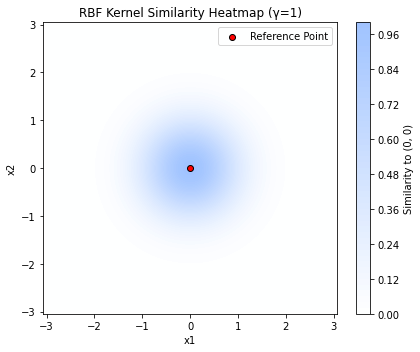

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define the RBF kernel function
def rbf_kernel(x, x_prime, sigma=0.5):
    return np.exp(-np.linalg.norm(x - x_prime) ** 2)

# Create a grid of 2D points
x1 = np.linspace(-3, 3, 200)
x2 = np.linspace(-3, 3, 200)
xx, yy = np.meshgrid(x1, x2)
grid = np.c_[xx.ravel(), yy.ravel()]

# Define the reference point
x_ref = np.array([0.0, 0.0])

# Compute similarities to the reference point
similarities = np.array([rbf_kernel(x, x_ref, sigma=0.5) for x in grid])
similarities = similarities.reshape(xx.shape)

cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, similarities, levels=50, cmap=cm_0)
plt.colorbar(label="Similarity to (0, 0)")
plt.scatter(*x_ref, color='red', label="Reference Point", edgecolor='black')
plt.title("RBF Kernel Similarity Heatmap (γ=1)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


### Inference
We recall from Eq.{eq}`primal_optimal` that the optimal parameters of a soft- and hard-margin SVM model $f_{svm}(\vvec{x})=\vvec{w}^\top\vvec{x} +b$ are given as
\begin{align*}
{\bf w}^{\ast} &= \sum_{i=1}^{n} \lambda_{i}^{\ast} y_{i} {\bf x}_{i}\\
b^{\ast} &= y_{i} - {{\bf w}^{\ast}}^\top {\bf x}_{i}  \quad\text{ for any }i\text{ such that } \lambda_{i} > 0 ,
\end{align*}
Hence, the SVM prediction can be computed for a linear kernel $k$ as
\begin{align*}
f_{svm}(\vvec{x})& =\sum_{i=1}^{n} \lambda_i^* y_i \vvec{x}_i^\top\vvec{x} +b^*\\
&= \sum_{i=1}^n \lambda_i^* y_i k(\vvec{x}_i,\vvec{x}) +b^*.
\end{align*}
The bias $b^*$ can be computed based on the kernel by substituting the optimal $\vvec{w}^*$ in the definition of the optimal $b^*$. Let $i$ be such that $\lambda_i>0$, then we have for a linear kernel $k$
\begin{align*}
b^{\ast} &= y_{i} - {{\bf w}^{\ast}}^\top {\bf x}_{i} \\
&= y_{i} - \sum_{j=1}^{n} \lambda_j^* y_j \vvec{x}_j^\top {\bf x}_{i}\\
&= y_{i} - \sum_{j=1}^{n} \lambda_j^* y_j k(\vvec{x}_j, {\bf x}_{i})
\end{align*}
Now, we can replace the linear kernel with any other kernel function and we can perform predictions for a kernel SVM without having to compute the feature transformation that defines the kernel.
```{prf:definition} kernel SVM
An kernel SVM classifier for a binary classification problem ($y\in\{-1,1\}$) reflects the distance to the decision boundary in a transformed feature space $\vvec{w}^\top \phi(\vvec{x})+b=0$
$$f_{ksvm}(\vvec{x}) = \vvec{w}^\top \phi(\vvec{x})+b.$$
Given a training data set $\mathcal{D}=\{(\vvec{x}_i,y_i)\mid 1\leq i\leq n\}$ and a kernel function $k$, the kernel SVM classifier computes its predictions by
\begin{align*}
f_{svm}(\vvec{x})
&= \sum_{i=1}^n \lambda_i y_i k(\vvec{x}_i,\vvec{x}) +b\\
b&= y_{i} - \sum_{j=1}^{n} \lambda_j y_j k(\vvec{x}_j, {\bf x}_{i})
\end{align*}
for some specified $\lambda_i\geq 0$.
The class predictions are then computed as
$$\hat{y} = \sign(f_{svm}(\vvec{x})).$$
```

### Optimization
The quadratic program objective of the SVM (see Eq.{eq}`svm_form10`) is perfect for applying a kernel. The data points occur in this objective only over the inner product in the computation of $DD^\top$, which computes the linear kernel matrix. We can replace $DD^\top$ with a kernel matrix and obtain the kernel SVM objective
````{prf:definition} Quadratic Program Kernel Soft-Margin SVM
Given a kernel matrix $K\in\mathbb{R}^{n\times n}$. The optimization objective of the kernel soft-margin SVM is given by the following quadratic program
```{math}
:label: kernel_svm
\begin{align*}
\min_{\boldsymbol{\lambda}}  \ & \frac14\bm{\lambda}^\top  \diag(\vvec{y})K\diag(\vvec{y}) \boldsymbol{\lambda} + {\bf 1}^\top \boldsymbol{\lambda} \\
\text{s.t. } &   \boldsymbol{\lambda}^\top{\bf y}  = 0 \\
&  0 \leq \lambda_{i} \leq C, \text{ for }1\leq i\leq n,
\end{align*} 
```

where $\mathbf{1}\in\{1\}^n$ is the constant one vector. 
````
The quadratic program above is still convex and therefore we can compute the global optimum with a convex solver.

### Decision Boundary
The plots below show the decision boundaries for the kernel SVM, using an RBF and a polynomial kernel. Both kernels are able to find decision boundaries that separate the training and test-data well. However, we also observe some undesired properties of the RBF kernel solution. The decision boundaries suggest that the classifier cuts out an area that is designated to predict the blue class, while the red class is the default class that is predicted otherwise. For the two moons, this does not make sense, since points that are on the top left are on the side of the blue moon and should be assigned to the blue moon. However, the classifier does not know of this intuition and hence we get here a different interpretation of the data by the classifier. When we can plot the data it is easy to see what is potentially problematic with a model, but in higher dimensions this becomes much more difficult.

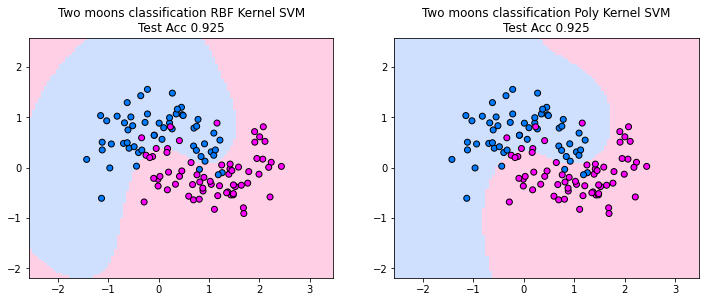

In [24]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.datasets import make_moons
from sklearn.svm import SVC


X,y = make_moons(noise=0.3, random_state=0, n_samples=200)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
# Define two SVM classifiers
svm_rbf = SVC(kernel='rbf', C=1.0, gamma=1.0)
svm_poly = SVC(kernel='poly', degree=3, C=1.0, coef0=1)

# Fit the models
y_pred_rbf = svm_rbf.fit(X_train, y_train)
y_pred_poly = svm_poly.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm = ListedColormap(["#a0c3ff", "#ffa1cf"])
cm_points = ListedColormap(["#007bff", "magenta"])

disp = DecisionBoundaryDisplay.from_estimator(
    svm_rbf,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    alpha=0.5,
    ax=axes[0],
    cmap=cm,
)
scatter = axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k",cmap = cm_points)
_ = axes[0].set_title(
    f"Two moons classification RBF Kernel SVM\nTest Acc {np.mean(svm_rbf.predict(X_test) == y_test)}"
)
axes[0].axis('scaled')

disp = DecisionBoundaryDisplay.from_estimator(
    svm_poly,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    alpha=0.5,
    ax=axes[1],
    cmap=cm,
)
scatter = axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k",cmap = cm_points)
_ = axes[1].set_title(
    f"Two moons classification Poly Kernel SVM\nTest Acc {np.mean(svm_poly.predict(X_test) == y_test)}"
)
axes[0].axis('scaled')
axes[1].axis('scaled')

plt.show()


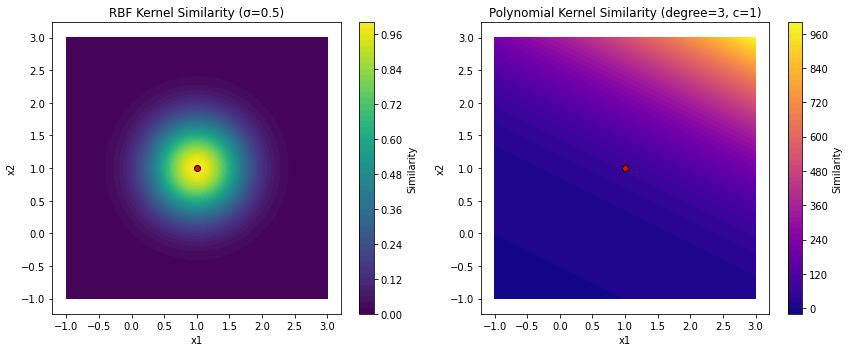

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the RBF kernel function
def rbf_kernel(x, x_prime, sigma=0.5):
    return np.exp(-np.linalg.norm(x - x_prime) ** 2 / (2 * sigma ** 2))

# Define the Polynomial kernel function
def poly_kernel(x, x_prime, degree=2, c=-1):
    return (np.dot(x, x_prime) + c) ** degree

# Create a grid of 2D points
x1 = np.linspace(-1, 3, 200)
x2 = np.linspace(-1, 3, 200)
xx, yy = np.meshgrid(x1, x2)
grid = np.c_[xx.ravel(), yy.ravel()]

# Define the reference point
x_ref = np.array([1.0, 1.0])

# Compute similarities for RBF and Polynomial kernels
similarities_rbf = np.array([rbf_kernel(x, x_ref, sigma=0.5) for x in grid]).reshape(xx.shape)
similarities_poly = np.array([poly_kernel(x, np.array([1.0, 2.0]), degree=3, c=1) for x in grid]).reshape(xx.shape)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RBF Kernel heatmap
c1 = axes[0].contourf(xx, yy, similarities_rbf, levels=50, cmap='viridis')
axes[0].scatter(*x_ref, color='red', label="Reference Point", edgecolor='black')
axes[0].set_title("RBF Kernel Similarity (σ=0.5)")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].axis('equal')
fig.colorbar(c1, ax=axes[0], label="Similarity")

# Polynomial Kernel heatmap
c2 = axes[1].contourf(xx, yy, similarities_poly, levels=50, cmap='plasma')
axes[1].scatter(*x_ref, color='red', label="Reference Point", edgecolor='black')
axes[1].set_title("Polynomial Kernel Similarity (degree=3, c=1)")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].axis('equal')
fig.colorbar(c2, ax=axes[1], label="Similarity")

plt.tight_layout()
plt.show()
